In [0]:

# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
# dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
# dbutils.widgets.dropdown("new_training", "False", ["True","False"])
# dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.dropdown("data_load_type", "Full", ["Full"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
data_load_type = dbutils.widgets.get("data_load_type") # Full/Incremental
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name, data_load_type)



dev bimodelapi False cc-bi-ml-devqa01 Full

In [0]:
%run ../../bi_config/pbi_common

In [0]:

# ============================= pyspark libraries import ===================================#
from pyspark.sql.functions import (
    col,
    concat,
    lit,
    current_date,
    lag,
    lead,
    first,
    last,
    desc,
    hash,
    row_number,
)
from datetime import date, timedelta, datetime
from pyspark.sql import functions as F
from pyspark.sql import *
from delta.tables import *
from pyspark.sql.types import TimestampType, LongType, StringType

# from ibi_packages import functions as fn
import os
import stringcase
from pyspark.sql import SQLContext
from pyspark.sql.window import Window

import pandas as pd


In [0]:

# ================= Load BI config parameters data (overwrite) =================#W
# static variables
environment_name = environment
filename = "automlrevfoecastconfig.json"

today = pd.to_datetime("today").normalize()
current_eom = today + pd.offsets.MonthEnd(0)
start_date = "2017-01-01"
end_date = current_eom + pd.offsets.MonthEnd(11)

notebook = os.path.basename(getNotebookPath())

input_data_path = "/dbfs/mnt/" + environment + "/automl_rev_region_forecast/inputs/"
output_data_path = "/dbfs/mnt/" + environment + "/automl_rev_region_forecast/outputs/"
blobstore_datadir = "revregionforecast_data/"

bi_config_parameter_filepath = "/mnt/{}/automl_rev_region_forecast/config/{}".format(
    environment_name, filename
)

try:
    # read JSON file
    df_bi_config_parameters = (
        spark.read.format("json")
        .option("multiline", "true")
        .load(bi_config_parameter_filepath)
    )
    df_bi_config_parameters = df_bi_config_parameters.filter(
        df_bi_config_parameters.SystemName == lit(system_name)
    )
    display(df_bi_config_parameters)

    # adding audit fields
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBICreatedBy",lit(ibi_created_by))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBIUpdatedBy",lit(ibi_updated_by))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBICreatedDate",lit(ibi_created_date).cast(TimestampType()))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBIUpdatedDate",lit(ibi_updated_date).cast(TimestampType()))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn('ID', row_number().over(Window.orderBy('EnvironmentName','SystemName')))

    # initializing config parameter values

    # subscription_id = "db61fd47-db56-45e3-844f-1b1f5c47990a" #you should be owner or contributor
    if environment in {"prod"}:
        subscription_id = dbutils.secrets.get(
            scope="kv-bi-prod-01-secrets", key="subscription-id"
        )
    else:
        subscription_id = dbutils.secrets.get(
            scope="kv-bi-devqa-01-secrets", key="subscription-id"
        )
        

    resource_group = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "ws_resource_group"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )
    workspace_name = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "workspace_name"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )
    workspace_region = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "workspace_region"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )


except Exception as error:
    log_error("{} {}".format(notebook, error))
    raise error #raise the exception



EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


Loading Market indices
0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,

End_of_Month,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
2016-01-31T00:00:00.000+0000,874.2999877929688,6083.7998046875,17518.30078125,1940.239990234375,2737.60009765625
2016-02-29T00:00:00.000+0000,849.9500122070312,6097.10009765625,16026.759765625,1932.22998046875,2687.97900390625
2016-03-31T00:00:00.000+0000,864.4099731445312,6174.89990234375,16758.669921875,2059.739990234375,3003.9150390625
2016-04-30T00:00:00.000+0000,869.8900146484375,6241.89990234375,16666.05078125,2065.300048828125,2938.323974609375
2016-05-31T00:00:00.000+0000,884.1699829101562,6230.7998046875,17234.98046875,2096.949951171875,2916.615966796875
2016-06-30T00:00:00.000+0000,846.469970703125,6504.2998046875,15575.919921875,2098.860107421875,2929.60595703125
2016-07-31T00:00:00.000+0000,876.010009765625,6724.39990234375,16569.26953125,2173.60009765625,2979.339111328125
2016-08-31T00:00:00.000+0000,875.9500122070312,6781.5,16887.400390625,2170.949951171875,3085.490966796875
2016-09-30T00:00:00.000+0000,881.47998046875,6899.2998046875,16449.83984375,2168.27001953125,3004.702880859375
2016-10-31T00:00:00.000+0000,881.7899780273438,6954.2001953125,17425.01953125,2126.14990234375,3100.491943359375


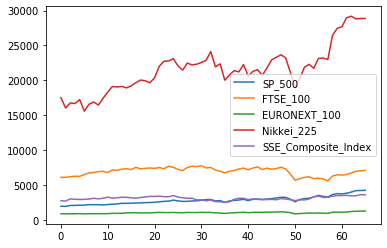

In [0]:

# download adjusted closing prices from Yahoo finance
# !pip install pandas_datareader
# !pip install yfinance
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

pd.set_option("display.float_format", lambda x: "%.2f" % x)

start = datetime.datetime(2016, 1, 1)
end = today

print("Loading Market indices")

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
symbols = [
    "^GSPC",
    "^FTSE",
    "^N100",
    "^N225",
    "000001.SS",
]
symbols_name = [
    "SP_500",
    "FTSE_100",
    "EURONEXT_100",
    "Nikkei_225",
    "SSE_Composite_Index",
]


# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in symbols:

    # print the symbol which is being downloaded
    print(str(symbols.index(i)) + str(" : ") + i, sep=",", end=",", flush=True)

    try:
        # download the stock price
        stock = []
        stock = yf.download(i, start=start, end=end, progress=False)

        # append the individual stock prices
        if len(stock) == 0:
            None
        else:
            stock["Name"] = i
            stock_final = stock_final.append(stock, sort=False)
    except Exception as error:
        print(error)
        log_error("{} {}".format(notebook, error)) #log error in sentry
        raise dbutils.notebook.exit(error) #raise the exception

# display(stock_final.tail())

stock_final1 = stock_final.copy()
stock_final1 = stock_final1.reset_index(level=stock_final1.index.names)

stock_final1["Name"].where(stock_final1["Name"] != "^N225", "Nikkei_225", inplace=True)
stock_final1["Name"].where(
    stock_final1["Name"] != "000001.SS", "SSE_Composite_Index", inplace=True
)
stock_final1["Name"].where(stock_final1["Name"] != "^GSPC", "SP_500", inplace=True)
stock_final1["Name"].where(stock_final1["Name"] != "^FTSE", "FTSE_100", inplace=True)
stock_final1["Name"].where(
    stock_final1["Name"] != "^N100", "EURONEXT_100", inplace=True
)

stock_final1["End_of_Month"] = stock_final1["Date"] + pd.offsets.MonthEnd(0)


# display(stock_final1.tail())
stock_final1 = stock_final1.sort_values("Date").groupby(["End_of_Month", "Name"]).last()
stock_final1 = stock_final1.drop(
    ["Date", "Open", "High", "Low", "Close", "Volume"], axis=1
)
stock_final1 = stock_final1.reset_index(level=stock_final1.index.names)

# Drop all Not a number values using drop method.
stock_final1.dropna(inplace=True)
stock_final_pivot = stock_final1.pivot_table(
    index="End_of_Month", values="Adj Close", margins=False, columns=["Name"]
)
# aggfunc=['sum','count'],

# revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})

stock_final_pivot = stock_final_pivot.reset_index(
    level=stock_final_pivot.index.names
).reset_index(drop=True)

# revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
# revhist_pivot.index.name = 'Date'

stock_final_pivot.fillna(0, inplace=True)
# stock_final_pivot = stock_final_pivot.ffill(axis = 0)
# stock_final1.query('Name=="Nikkei 225"').plot(title=str(i))
#display(stock_final_pivot.info())
#display(stock_final_pivot.tail())
display(stock_final_pivot)
for i in symbols_name:
    stock_final_pivot[i].plot(legend=True)



In [0]:

# Load Power BI Data into pandas Dataframe
# https://stbidatadevqa01.dfs.core.windows.net/dev/automl_rev_region_forecast

# Ingest power bi data

import glob

init_time_column_name = "End_of_Month"
init_time_column_name1 = "Snapshot_Date"
#init_time_column_name2 = "Snapshot_End_of_Month"

print("First load and transforming with underscore column names")

try:
    talenthist = pd.read_csv(
        input_data_path + "TalentHistory.csv", parse_dates=[init_time_column_name]
    )

    revhist = pd.read_csv(
        input_data_path + "RevenueHistory.csv", parse_dates=[init_time_column_name]
    )
    opphist = pd.read_csv(
        input_data_path + "OppHistory.csv", parse_dates=[init_time_column_name]
    )
    projhist = pd.read_csv(
        input_data_path + "ProjectHistory.csv", parse_dates=[init_time_column_name]
    )
    pipetrend = pd.read_csv(
        input_data_path + "PipelineTrend.csv",
        #parse_dates=[init_time_column_name1, init_time_column_name],
        parse_dates=[init_time_column_name1, init_time_column_name],
    )
    projectactualshist = pd.read_csv(
        input_data_path + "ProjectActualsHistory.csv",
        parse_dates=[init_time_column_name],
    )

    # pipehist = pd.read_csv(input_data_path + 'PipelineHistory*.csv',
    #                       parse_dates=[init_time_column_name,
    #                       init_time_column_name1])

    pipehist = pd.concat(
        [
            pd.read_csv(f, parse_dates=[init_time_column_name, init_time_column_name1])
            for f in glob.glob(input_data_path + "PipelineHistory*.csv")
        ],
        ignore_index=True
    )

    # Remove Percentage from numbers if existinput_data_path + 'PipelineHistory*.csv'

    # opphist1.filter(like="Win_Rate", axis=1).columns
    '''
    cols_float1 = ["Win Rate"]
    remove_percetage(opphist, cols_float1)
    cols_float2 = ["Yield"]
    remove_percetage(pipehist, cols_float2)
    cols_float3 = ["Utilization Billable"]
    remove_percetage(projectactualshist, cols_float3)
    '''
    file_list = [
        pipehist,
        talenthist,
        revhist,
        opphist,
        projhist,
        pipetrend,
        projectactualshist
    ]

    for x in file_list:

        # replace blank with underscore

        x.columns = x.columns.astype(str).str.replace(" ", "_")

        # remove contrib or managing

        x.columns = x.columns.astype(str).str.replace("Contrib_", "")
        x.columns = x.columns.astype(str).str.replace("Managing_", "")
#         x.columns = x.columns.astype(str).str.replace("Sub Region Code", "Sub_Region_Code")
#         x.columns = x.columns.astype(str).str.replace("Relative Snapshot Month Offset", "Relative_Snapshot_Month_Offset")
        
        #display(x.info())
        print(get_df_name(x), ":", x.shape)
        #pd.DataFrame(x.describe(include='all').T)
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception

First load and transforming with underscore column names
pipehist : (89602, 9)
talenthist : (4760, 6)
revhist : (533, 3)
opphist : (422, 9)
projhist : (548, 7)
pipetrend : (1326, 4)
projectactualshist : (2364, 5)